In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/MyDrive/SpeechEnhancement'

/content/drive/MyDrive/SpeechEnhancement


In [4]:
!pip install pesq

  Created wheel for pesq: filename=pesq-0.0.3-cp37-cp37m-linux_x86_64.whl size=210465 sha256=f0d2bdf891c9ff2dde911ca9e1e1bf476afb631f51f0cfb67ad91743be40c935
  Stored in directory: /root/.cache/pip/wheels/4f/67/5b/aa7cf31fe0c7199e35c604bb7bc91c629a13726bf221fedba0
Successfully built pesq


In [5]:
import numpy as np
import wave
import matplotlib.pyplot as plt
import math
from pesq import pesq

In [6]:
def denoise(cleanfile,noisyfile,noisyDb):
  #Read clean wavfile
  clean_stream = wave.open(cleanfile)
  clean_params = clean_stream.getparams()
  nchannels_clean, sampwidth_clean, fs_clean, nframes_clean = clean_params[:4]
  clean_data = clean_stream.readframes(nframes_clean)
  clean_stream.close()

  # convert waveform data to an array
  clean = np.frombuffer(clean_data, dtype=np.short)

  #Read noisy wavfile
  stream = wave.open(noisyfile)
  params = stream.getparams()
  nchannels, sampwidth, fs, nframes = params[:4]
  data_arr = stream.readframes(nframes)
  stream.close()

  # convert waveform data to an array
  data = np.frombuffer(data_arr, dtype=np.short)

  # calculation parameters
  N = 20 * fs // 1000      # frame size in samples
  L = 50                   # window overlap in percent of frame
  len1 = N * L // 100   # overlap length
  len2 = N - len1          # window length - overlap length
  Thres = 3 #Threshold for unvoiced and voiced speech   
  b = 0 #Spectral subtraction parameter
  
  # sine window
  win = np.hamming(N)
  winGain = len2 / sum(win)
  nFFT = 512
  noise_mean = np.zeros(nFFT)
  j = 1

  #Estimating noise mean magnitude from unvoiced speech. Unvoiced speech could be in the first 5 frames
  for k in range(1, 6):
    noise_mean = noise_mean + abs(np.fft.fft(win * data[j:j + N], nFFT))
    j = j + N
  noise_mu = noise_mean / 5
  
  k = 1
  data_old = np.zeros(len1)
  Nframes = len(data) // len2 - 1
  recon = np.zeros(Nframes * len2)

  #Frame whole data
  data_matrix = []
  for m in range(0,Nframes):
    data_matrix.append(win*data[k-1:k+N-1])
    k = k+len2

  k = 1
  for n in range(0, Nframes):
    frame = win*data[k-1:k+N-1]
    transform = np.fft.fft(frame,nFFT)
    freqbins = np.fft.fftfreq(nFFT)*fs
    mag = abs(transform)
    theta = np.angle(transform)

    #Weighted spectrum
    if(n<Nframes-2 and n>1):
      mag = 0.09*abs(np.fft.fft(data_matrix[n-2],nFFT)) + 0.25*abs(np.fft.fft(data_matrix[n-1],nFFT)) + 0.32*abs(np.fft.fft(data_matrix[n],nFFT)) + 0.25*abs(np.fft.fft(data_matrix[n+1],nFFT)) + 0.09*abs(np.fft.fft(data_matrix[n+2],nFFT))
    power_mag = mag**2
    
    #SNR of the segment
    power_noise = noise_mu ** 2
    SNRseg = 10 * np.log10(np.sum(power_mag) / np.sum(power_noise))

    #Multi-band factor
    delta = 1.0
    for l in range(nFFT):
      if(freqbins[l]<=1000):
        delta = 1.0
      elif(freqbins[l]<=(fs/2-2000)):
        delta = 2.5
      else:
        delta = 1.5
      power_noise[l] = power_noise[l]*delta

    #Spectral subtraction
    if(SNRseg>20):
      power_sub_speech = power_mag - power_noise
    elif(SNRseg>=-5):
      power_sub_speech = power_mag - (4-(3/20)*SNRseg)*power_noise
    else:
      power_sub_speech = power_mag - 5*power_noise

    #Make subtracted speech negative components equal to zero
    def find_negative(inList):
        index_list = []
        for i in range(len(inList)):
            if inList[i] < 0:
                index_list.append(i)
        return index_list
    neg_Indices = find_negative(power_sub_speech)
    if len(neg_Indices) > 0:
        power_sub_speech[neg_Indices] = 0
    
    #Update noise spectrum from unvoiced regions
    if(SNRseg<Thres):
       noise_temp = 0.9 * noise_mu + (1 - 0.9) * mag # Smoothing processing noise power spectrum
       noise_mu = noise_temp  # New noise amplitude spectrum

    x_phase = (power_sub_speech ** (1/2))*np.exp(1j*theta)
    xi = np.fft.ifft(x_phase).real
    
    #Overlap and add methods
    recon[k-1:k + len2 -1] = data_old + xi[0:len1]
    data_old = xi[0+len1:N]

    k = k+len2
  

   # save reconstructed wave file
  reconstream = wave.open('out-'+ 'spectral-sub-'+noisyfile, 'wb')

  # setting parameters
  reconstream.setparams(params)
  # set waveform file .tostring()Convert array to data
  recon_data = (winGain * recon).astype(np.short)
  reconstream.writeframes(recon_data.tobytes())
  # close wave file
  reconstream.close()

  # enchanced speech FFT
  es_FFT = abs(np.fft.fft(len2 / sum(win) * recon))

  # plot wave
  minval = np.min(abs(recon[np.nonzero(recon)]))
  recon[recon==0] = minval

  sr = fs
  print('PESQ of original noisy signal with refernce to clean signal = ' + str(pesq(sr,clean,data,'nb')))
  print('PESQ of original reconstructed signal with reference to clean signal = ' + str(pesq(sr,clean,recon,'nb')))

  fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(20,15))
  fig.tight_layout()
  fontsize = 20
  fig.suptitle('Multi-band spectral subtraction for noise level '+ str(noisyDb) + ' dB',fontsize=fontsize)
  axes[0,0].plot(clean)
  axes[0,0].set_title('Clean Speech',fontsize=fontsize)
  
  axes[1,0].plot(data)
  axes[1,0].set_title('Noisy Speech',fontsize=fontsize)
  
  axes[2,0].plot(len2 / sum(win) * recon)
  axes[2,0].set_title('Enhanced Speech',fontsize=fontsize)
  
  axes[0,1].specgram(clean,NFFT=nFFT,Fs=fs)
  axes[0,1].set_title('Clean Speech spectrogram',fontsize=fontsize)
 
  axes[1,1].specgram(data,NFFT=nFFT,Fs=fs)
  axes[1,1].set_title('Noisy Speech spectrogram',fontsize=fontsize)
  
  axes[2,1].specgram(recon,NFFT=nFFT,Fs=fs)
  axes[2,1].set_title('Reconstructed Speech spectrogram',fontsize=fontsize)

  plt.show()
   
  fig.savefig('Multiband_spectral_subtraction_results_noise_level_' + str(noisyDb) + '_dB.png')

PESQ of original noisy signal with refernce to clean signal = 1.4317066669464111
PESQ of original reconstructed signal with reference to clean signal = 1.7535470724105835


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


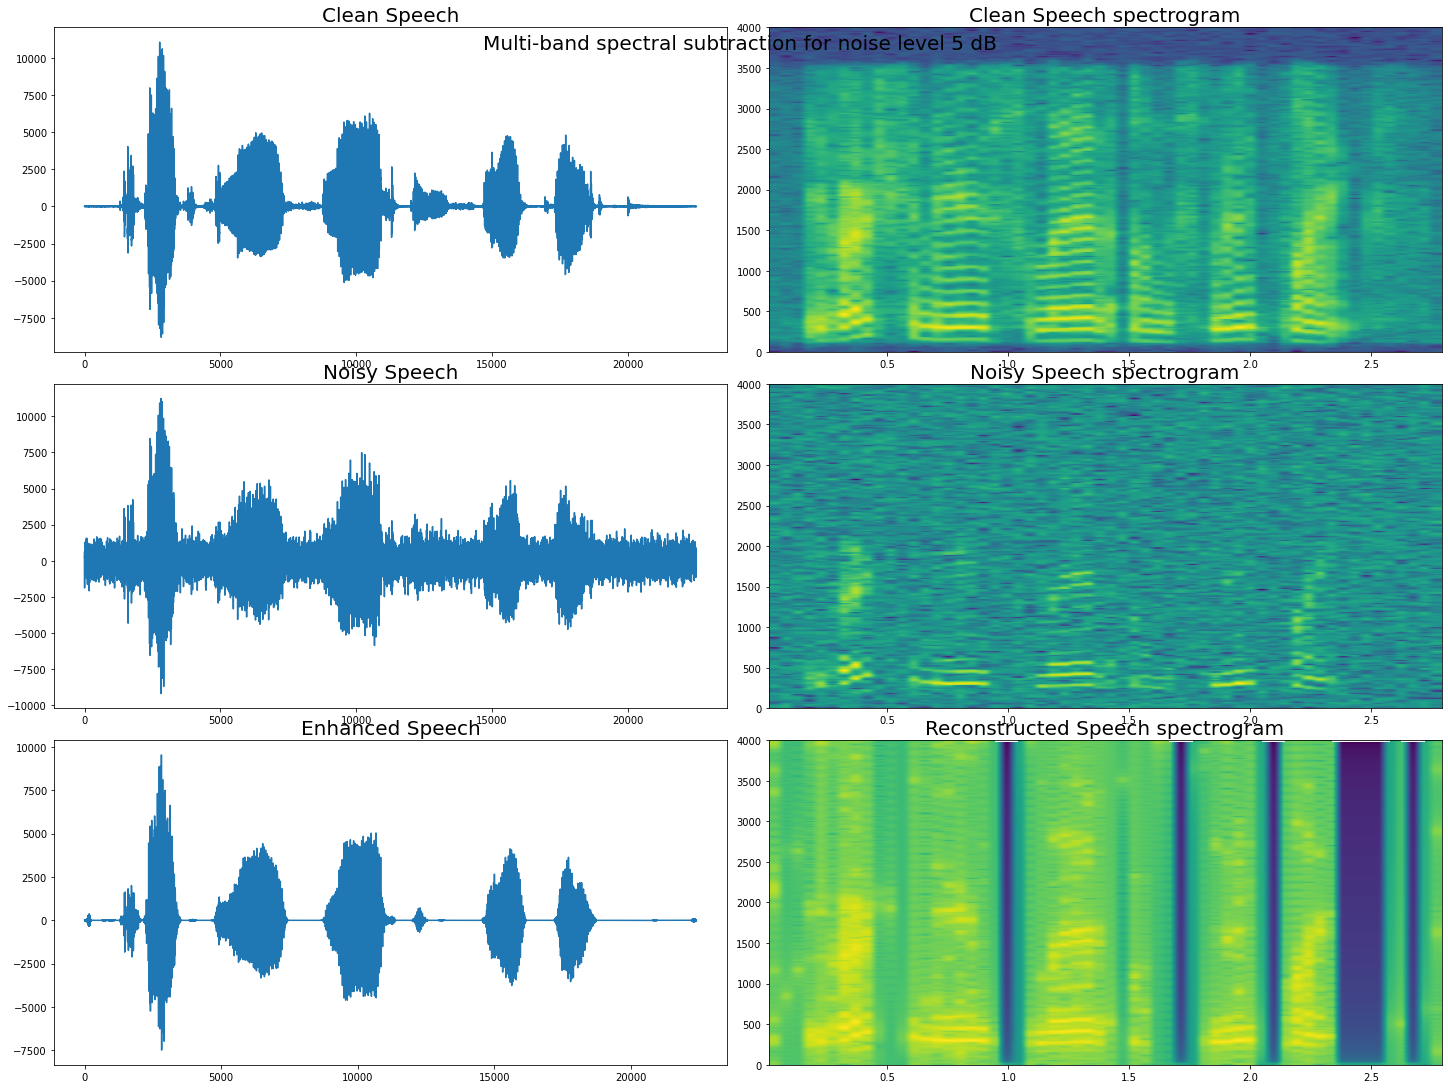

In [7]:
denoise('wiener_filtering_sp01.wav','wiener_filtering_in_SNR5_sp01.wav',5)

PESQ of original noisy signal with refernce to clean signal = 1.6795148849487305
PESQ of original reconstructed signal with reference to clean signal = 1.960010290145874


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


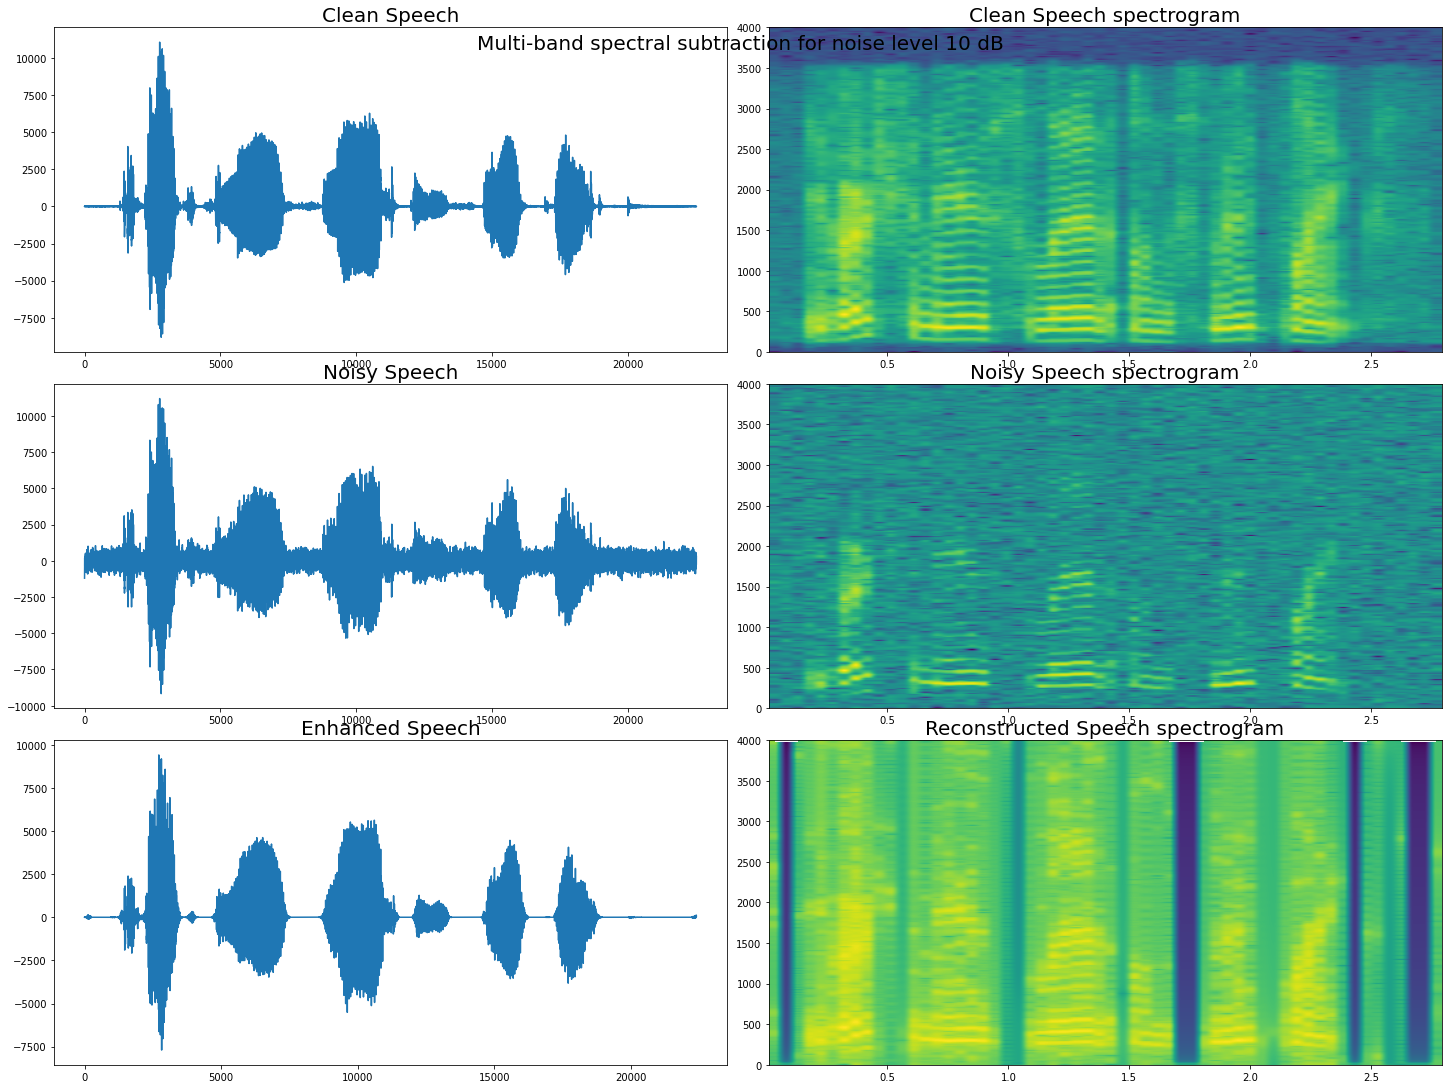

In [9]:
denoise('wiener_filtering_sp01.wav','wiener_filtering_in_SNR10_sp01.wav',10)

PESQ of original noisy signal with refernce to clean signal = 2.0232479572296143
PESQ of original reconstructed signal with reference to clean signal = 2.140491247177124


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


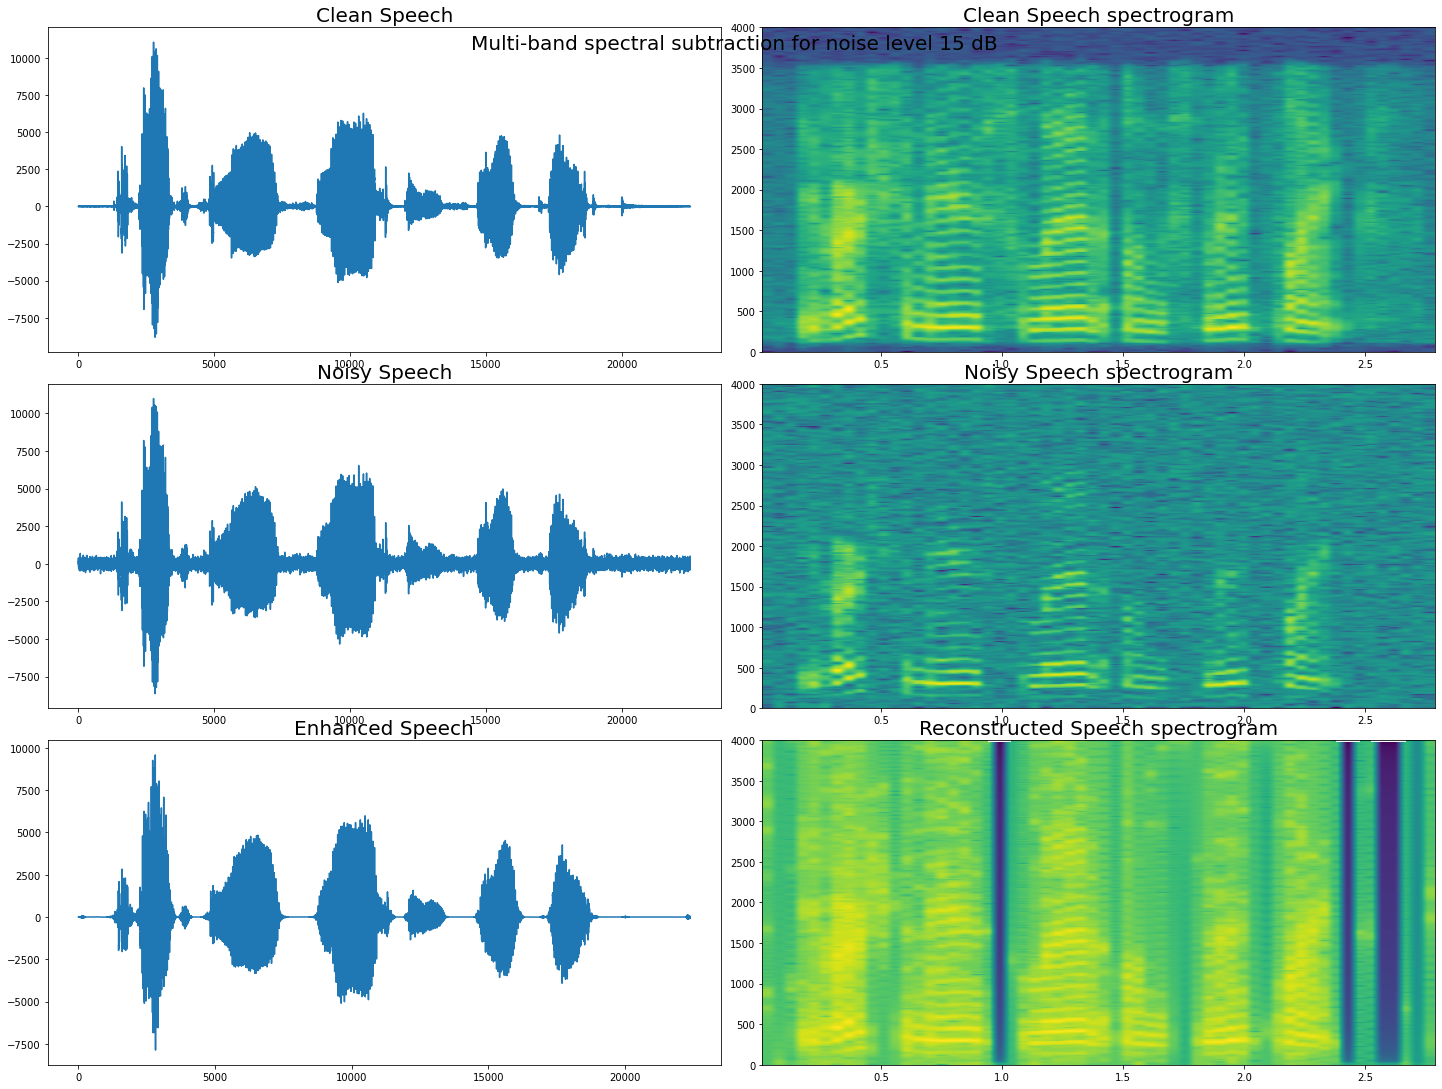

In [10]:
denoise('wiener_filtering_sp01.wav','wiener_filtering_in_SNR15_sp01.wav',15)

In [11]:
%cd 'Test Data'

/content/drive/MyDrive/SpeechEnhancement/Test Data


PESQ of original noisy signal with refernce to clean signal = 1.4063389301300049
PESQ of original reconstructed signal with reference to clean signal = 1.3772830963134766


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


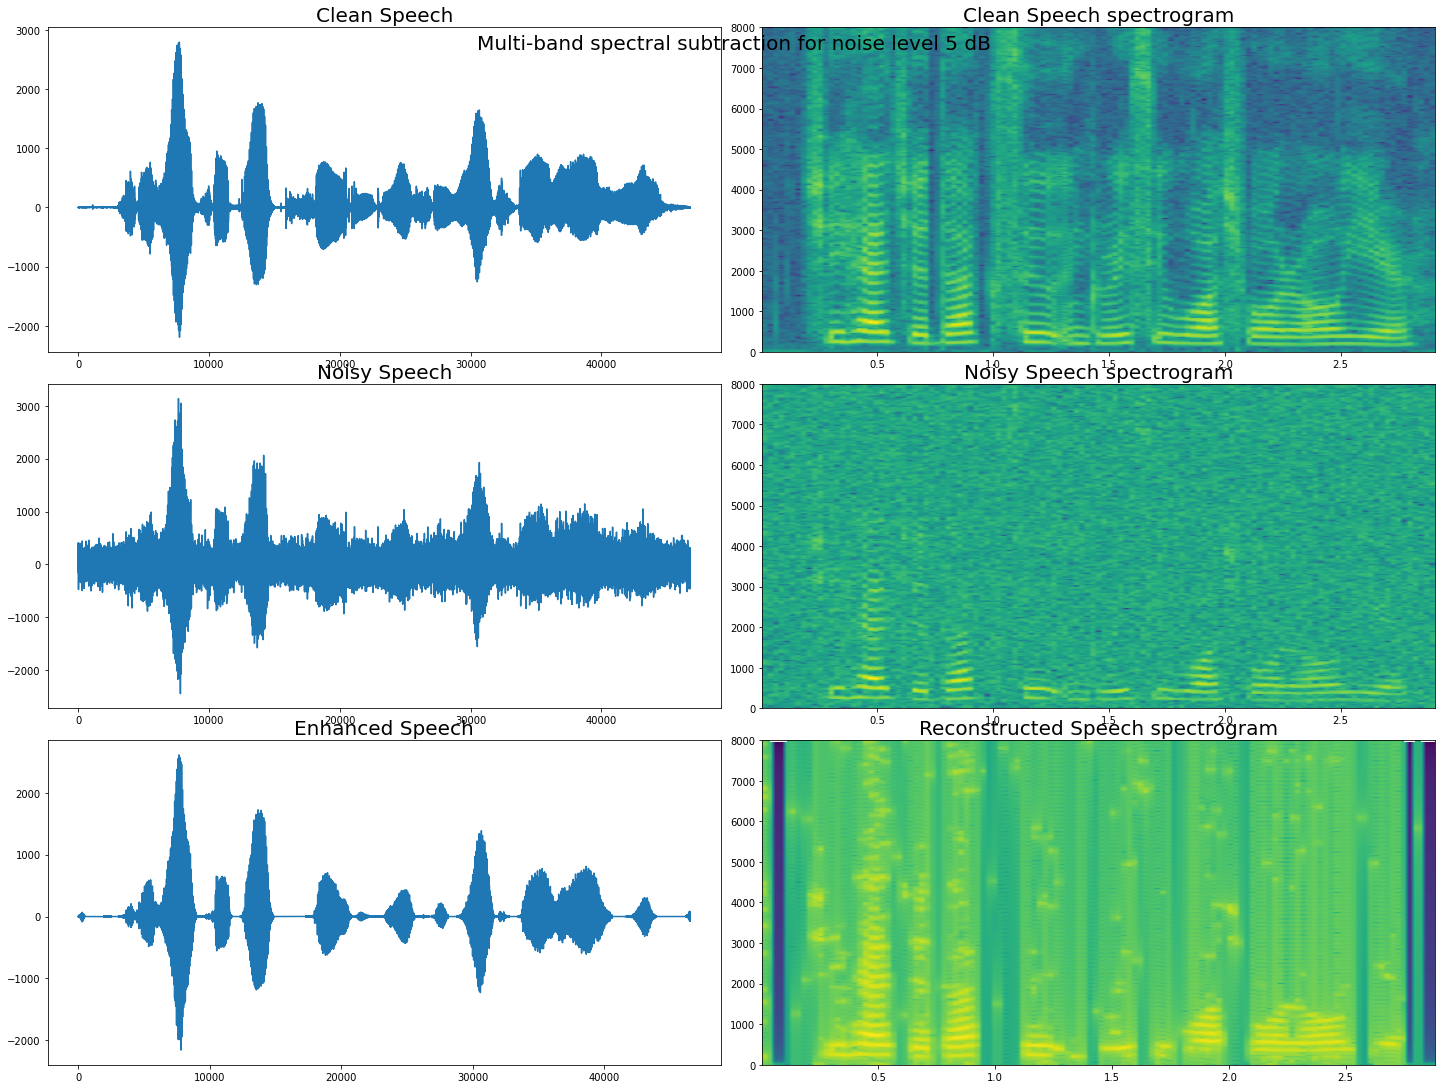

PESQ of original noisy signal with refernce to clean signal = 1.7529339790344238
PESQ of original reconstructed signal with reference to clean signal = 1.7475517988204956


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


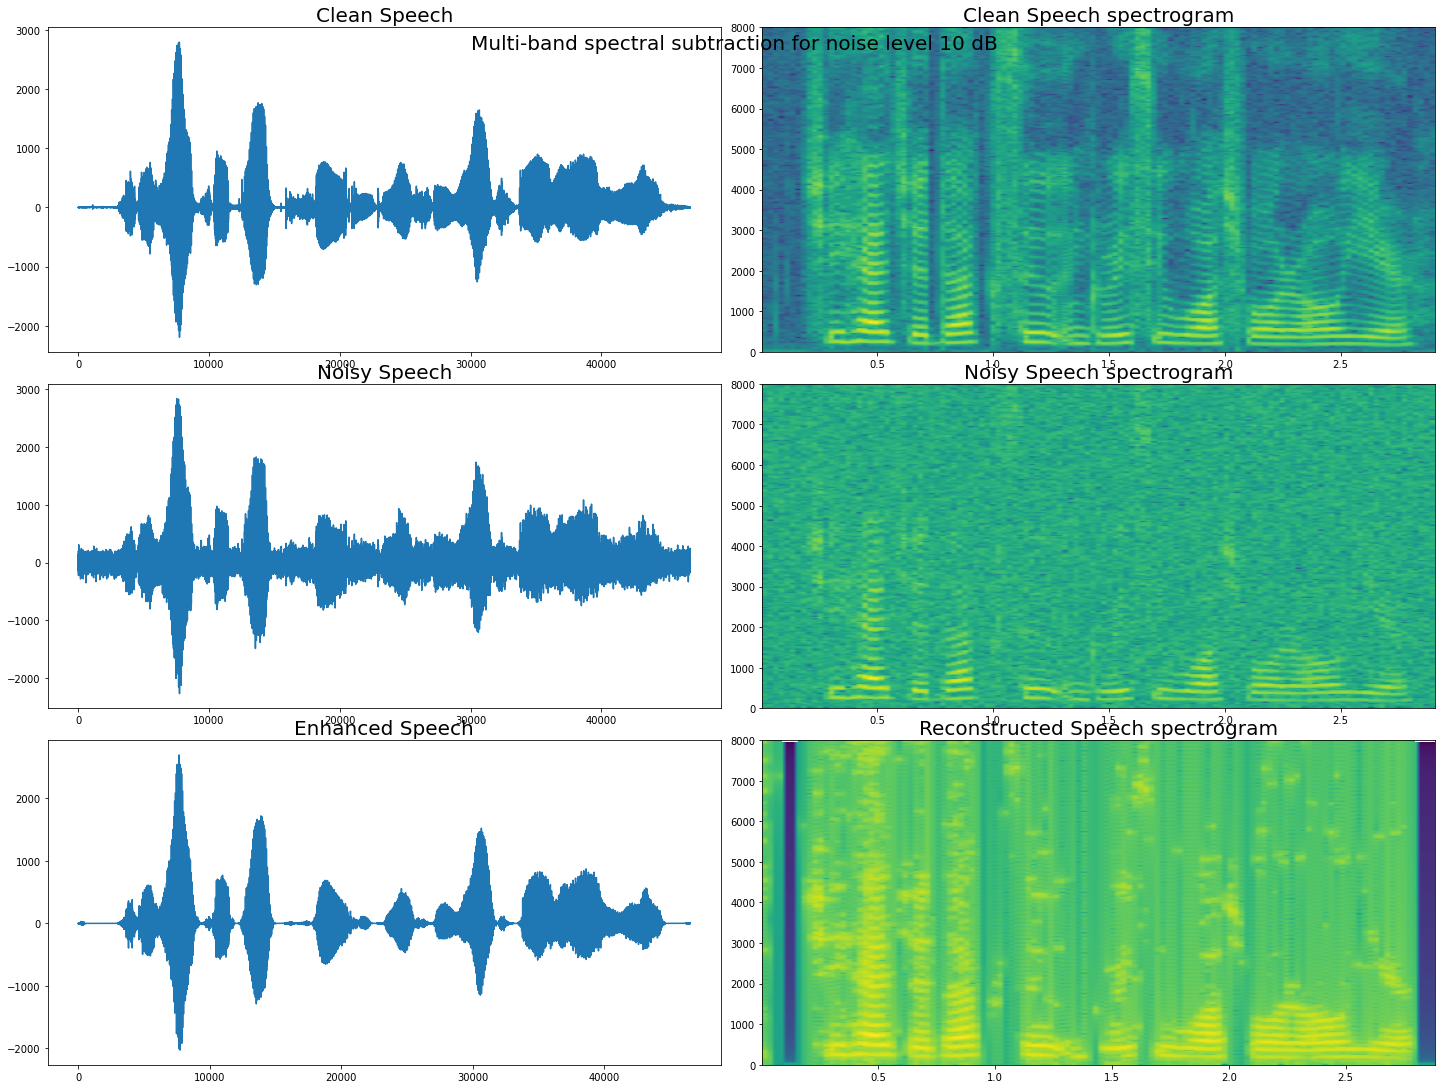

PESQ of original noisy signal with refernce to clean signal = 2.25164532661438
PESQ of original reconstructed signal with reference to clean signal = 2.3699278831481934


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


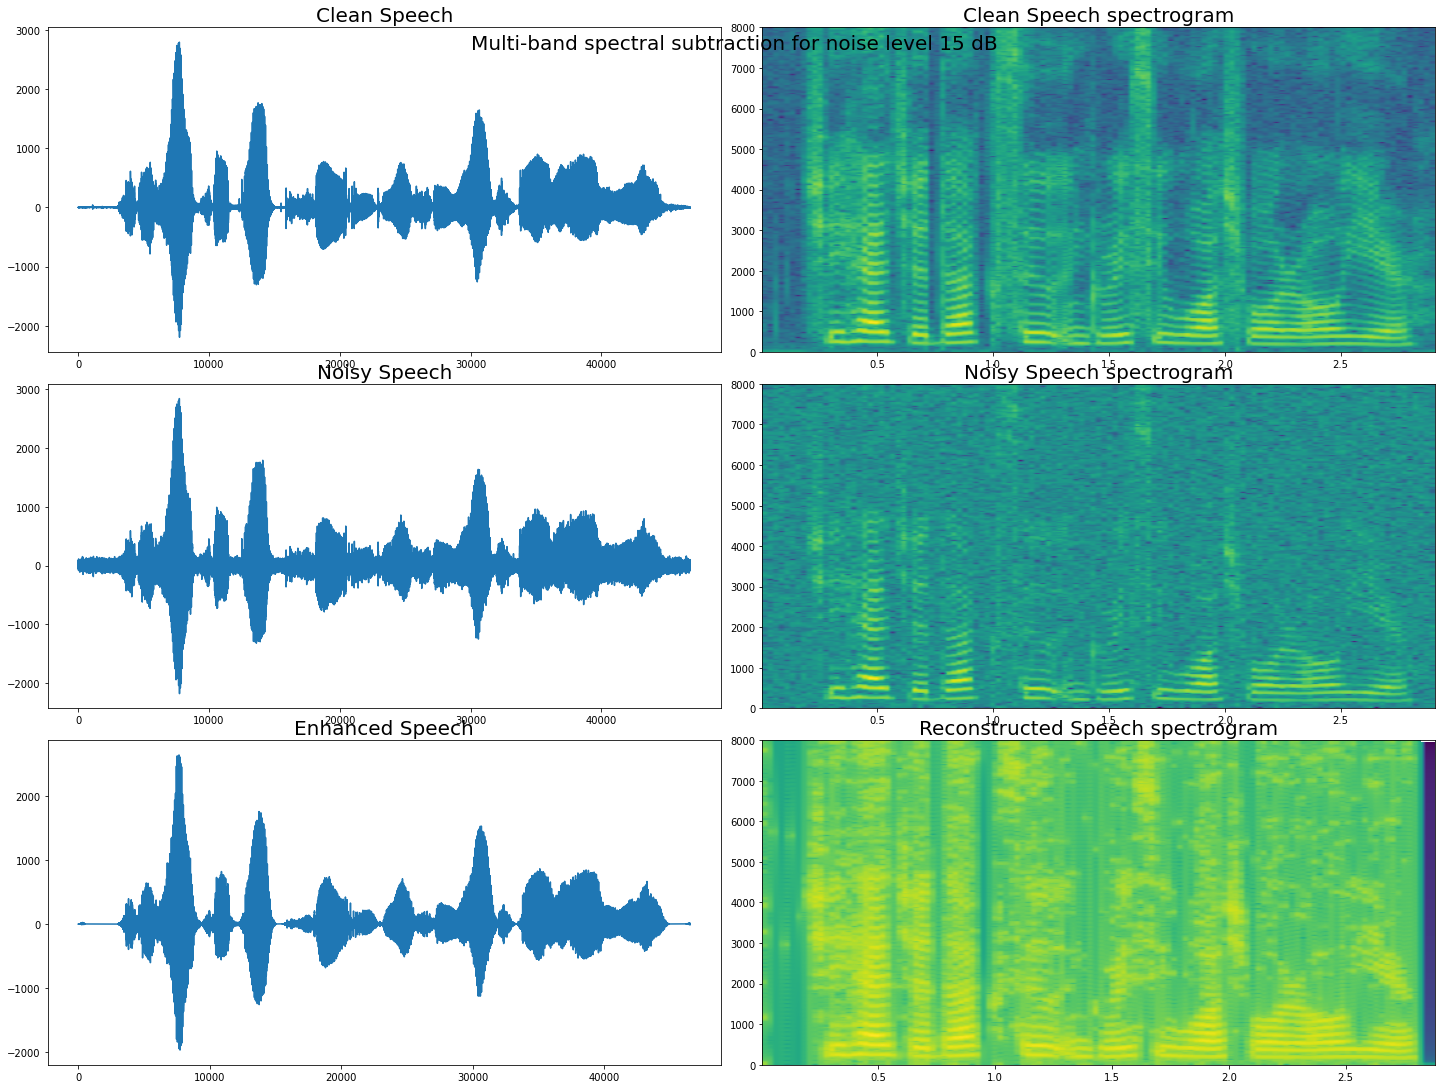

In [13]:
denoise('SA1_1.WAV','SA1_1_5DB.WAV',5)
denoise('SA1_1.WAV','SA1_1_10DB.WAV',10)
denoise('SA1_1.WAV','SA1_1_15DB.WAV',15)